In [1]:
import feedparser
import pandas as pd
import gensim
from gensim.models import Word2Vec
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk import word_tokenize
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
stop_words = stopwords.words('english')
from pyemd import emd
from scipy.cluster.hierarchy import fclusterdata
from sklearn.cluster import DBSCAN, AffinityPropagation, AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier, kneighbors_graph
import pickle
import time
import hashlib
from sklearn.exceptions import NotFittedError

#from itertools import combinations
#from tqdm import tqdm_notebook
#from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD, LatentDirichletAllocation

In [2]:
bbc_rss = ['http://feeds.bbci.co.uk/news/rss.xml', 
           'http://feeds.bbci.co.uk/news/world/rss.xml', 
           'http://feeds.bbci.co.uk/news/uk/rss.xml', 
           'http://feeds.bbci.co.uk/news/business/rss.xml', 
           'http://feeds.bbci.co.uk/news/politics/rss.xml', 
           'http://feeds.bbci.co.uk/news/health/rss.xml', 
           'http://feeds.bbci.co.uk/news/education/rss.xml', 
           'http://feeds.bbci.co.uk/news/science_and_environment/rss.xml', 
           'http://feeds.bbci.co.uk/news/technology/rss.xml', 
           'http://feeds.bbci.co.uk/news/entertainment_and_arts/rss.xml']

In [3]:
class Embeddings:
    
    def __init__(self, create=False, ser_model_path='W2VModel',
                 embeddings='GoogleNews-vectors-negative300.bin.gz',
                 model_fun=gensim.models.KeyedVectors.load_word2vec_format, binary=True, norm=True):
        self.ser_model = ser_model_path
        self.embeddings = embeddings
        self.model_fun = model_fun
        self.binary = binary
        self.norm = norm
        
        if create == False:
            self.model = self.load_model()
        else:
            self.model = self.create_model()
        
            
    def create_model(self):
        model = self.model_fun(self.embeddings, binary=self.binary)
        if self.norm:
            model.init_sims(replace=True)
        return model
            
    def load_model(self):
        with open(self.ser_model, 'rb') as file:
            model = pickle.load(file)
        return model

In [4]:
# ? TODO: dist_matrix(x,y) from two news vectors (if we want some classification based only on distances, + use wmd!)
class News_Vectorizer:
    
    def __init__(self, model, news=None):
        self.news = news #array of strings
        self.model = model #Word2Vec model
        if self.news is not None:
            self.news_vectors = self.news2vec(self.news) #vector representations
        else:
            self.news_vectors = None
        self.cos_dist = None #cosine distance matrix
        self.wm_dist = None #wmd-matrix
    
    def wmd(self, q1, q2):
        q1 = str(q1).lower().split()
        q2 = str(q2).lower().split()
        q1 = [w for w in q1 if w not in stop_words]
        q2 = [w for w in q2 if w not in stop_words]
        return self.model.wmdistance(q1, q2)
    
    def sent2vec(self, s):
        words = str(s).lower()
        words = word_tokenize(words)
        words = [w for w in words if not w in stop_words]
        words = [w for w in words if w.isalpha()]
        M = []
        for w in words:
            try:
                M.append(self.model[w])
            except:
                continue
        M = np.array(M)
        v = M.sum(axis=0)
        return v / np.sqrt((v ** 2).sum())
    
    def news2vec(self, news):
        # update self.news, self.news_vectors
        news_vectors = np.array([self.sent2vec(text) for text in news])
        self.news = news
        self.news_vectors = news_vectors
        #if self.news is None:
        #    self.news = news
        #if self.news_vectors is None:
        #    self.news_vectors = news_vectors
        return news_vectors
    
    def dist_vec(self, news_item, news=None, metric='cosine'):
        #computes distances between given item and news (or self.news)
        news_item = self.sent2vec(news_item)
        if news is not None:
            news = self.news2vec(news)
        else:
            news = self.news_vectors
        if news is None:
            return 'no news to compute distances'
        if metric == 'cosine':
            dist_vec = np.array([cosine(news_item, i) for i in news])
        elif metric == 'wmd':
            dist_vec = np.array([self.wmd(news_item, i) for i in news])
        return dist_vec
    
    def cosine_matrix(self): 
        cdist = np.zeros((len(self.news_vectors), len(self.news_vectors)))
        for n, i in enumerate(self.news_vectors):
            for m, j in enumerate(self.news_vectors):
                cdist[n, m] = cosine(i, j)
        self.cos_dist = cdist
        return cdist
    
    def wmd_matrix(self): #list (news)
        wmdist = np.zeros((len(self.news), len(self.news)))
        for n, i in enumerate(self.news):
            for m, j in enumerate(self.news):
                wmdist[n, m] = self.wmd(i, j)
        self.wm_dist = wmdist
        return wmdist

In [5]:
class RSS_Feeds:
    
    def __init__(self, urls):
        self.urls = urls
        self.feeds = self.get_feeds()
        self.df_news = self.create_df()
        self.df_unique_news = self.create_unique()
        
    def get_feeds(self):
        return [feedparser.parse(feed) for feed in self.urls]
    
    def get_category(self, feed):
        # sources may have different category names - agg categories?
        return feed.feed.get('title', '')

    def get_title_summary(self, feed, sep='. '): #get and join title and summary for each entry in feed
        titles = [entry['title'] for entry in feed['entries']]
        summaries = [entry['summary'] for entry in feed['entries']]
        title_summary = [entry['title'] + sep + entry['summary'] for entry in feed['entries']]
        return titles, summaries, title_summary
    
    def get_date(self, feed): #(year, month, day) for each entry in feed
        return([entry['published_parsed'][:3] for entry in feed['entries']])
    
    def get_time(self, feed): #(hour, min, sec) for each entry in feed
        return([entry['published_parsed'][3:6] for entry in feed['entries']])
    
    def get_datetime_nparsed(self, feed): #not parsed date and time for each entry in feed
        return([entry['published'] for entry in feed['entries']])
    
    def get_link(self, feed): # link for each entry in feed
        return([entry['link'] for entry in feed['entries']])
    
    def str2hash(self, s):
        return hashlib.md5(s.encode()).hexdigest()
    
    def create_df(self): 
        news, title, summary, category, pdate, ptime, fdatetime, links  = [], [], [], [], [], [], [], []
        for feed in self.feeds:
            cat = self.get_category(feed)
            titles, summaries, texts = self.get_title_summary(feed)
            d_ymd, t_hms = self.get_date(feed), self.get_time(feed)
            fdt = self.get_datetime_nparsed(feed)
            news_links = self.get_link(feed)
            
            cat = np.resize([cat], len(texts))
            news.extend(texts)
            title.extend(titles)
            summary.extend(summaries)
            pdate.extend(d_ymd)
            ptime.extend(t_hms)
            fdatetime.extend(fdt)
            links.extend(news_links)
            category.extend(cat)
        df_news = pd.DataFrame({'news':news, 
                                'category':category,
                                'title':title, 
                                'summary':summary,
                                'link':links,
                                'date':pdate, 
                                'time':ptime, 
                                'datetime':fdatetime})
        df_news['ID'] = df_news.news.apply(self.str2hash)
        self.df_news = df_news
        return df_news
    
    def create_unique(self):
        df_unique_news = self.df_news.groupby('news').agg({'category':list, 
                                                           'title': np.unique, 
                                                           'summary': np.unique, 
                                                           'link': np.unique, 
                                                           'date': np.unique, 
                                                           'time': np.unique, 
                                                           'datetime': np.unique, 
                                                           'ID': np.unique})
        df_unique_news.reset_index(inplace=True)
        self.df_unique_news = df_unique_news
        return df_unique_news
    
    def get_unique_news(self):
        return self.df_unique_news.news.values

In [6]:
#TODO: Weights!
#TODO: Classifier, Clusterizer -> with outlier clusters
#TODO: number of clusters - determine dynamically? Or/and choose another clusterizer...
# ? TODO: not only labels but also distances - to suggest the most interesting items?
class Aggregator:
    
    def __init__(self, clusterizer, classifier, labeled_data=None, labels=None, clust_weights=None):
        self.clusterizer = clusterizer
        self.classifier = classifier
        self.labeled_data = labeled_data #already clustered viewed, vector representations as ndarray
        self.labels = labels #clust nums of labeled_data, ndarray
        self.clust_weights = clust_weights # DataFrame, colnames=['clust', 'weight']
        
    def clusterize(self, data):
        labels = self.clusterizer.fit_predict(data)
        return data, labels
    
    def classify(self, new_data): #if one sample: reshape sent2vec output to (1, 300)
        try:
            predicted = self.classifier.predict(new_data)
        except NotFittedError as e:
            return(repr(e))
        return predicted
    
    def fit_classifier(self):
        X, y = self.labeled_data, self.labels
        self.classifier.fit(X, y)
        return self.classifier
    
    def prep_data(self, new_data=None):
        if self.labeled_data is None and new_data is None:
            return None
        else:
            try:
                ldata = pd.DataFrame(self.labeled_data)
            except:
                ldata = None
            try:
                ndata = pd.DataFrame(new_data)
            except:
                ndata=None
            try:
                data = pd.concat([ldata, ndata]).values
                return data
            except:
                return None
    
    def update_weights(self): #sum weights = 1 required in News_Finder
        unique, counts = np.unique(self.labels, return_counts=True)
        weights = counts/counts.sum() #smth like this
        weights = np.asarray((unique, weights)).T # [label, weight]
        self.clust_weights = pd.DataFrame({'clust': weights[:,0].astype(int), 'weight': weights[:,1]})
        return self.clust_weights
    
    def update_aggregator(self, new_data):
        data = self.prep_data(new_data=new_data)
        if data is None:
            return 'no data'
        else:
            self.labeled_data, self.labels = self.clusterize(data)    
            self.fit_classifier()
            self.update_weights()
            return 'updated'
        

In [172]:
class News_Finder():
    
    def __init__(self, df_news, news_vectorizer): #df_news: DF with non-viewed news items; News_Vectorizer instance
        self.df_news = df_news
        self.df_unique_news = self.create_unique()
        self.news_vectorizer = news_vectorizer
        
    def update_news(self, df_news):
        self.df_news = df_news
        self.df_unique_news = self.create_unique()
        return 'updated'
    
    def create_unique(self):
        df_unique_news = self.df_news.groupby('ID').agg({'news': np.unique, 
                                                         'category':list, 
                                                         'title': np.unique, 
                                                         'summary': np.unique, 
                                                         'link': np.unique, 
                                                         'date': np.unique, 
                                                         'time': np.unique, 
                                                         'datetime': np.unique})
        df_unique_news.reset_index(inplace=True)
        return df_unique_news
    
    def get_from_categories(self, n=5):
        # returns n top news from each category
        return self.df_news.groupby('category').head(n) 
    
    def get_similar(self, news_item_ID, metric='cosine', n=5):
        # returns the n most similar news to news_item
        all_news = self.df_unique_news.query('ID != @news_item_ID').copy()
        news_item = self.df_unique_news.query('ID == @news_item_ID').copy()
        dist_vec = self.news_vectorizer.dist_vec(news_item.news, all_news.news.values, metric=metric)
        all_news['dist'] = dist_vec
        return all_news.nsmallest(n, 'dist')
    
    def get_interesting(self, aggregator, n=20): #fitted Aggregator instance for classification & weights
        # TODO: return n news
        # TODO: if there are not enough news in clusters (for weights), return another news?
        all_news = self.df_unique_news.copy()
        news_vec = self.news_vectorizer.news2vec(all_news.news.values)
        #print(news_vec.shape)
        weights = aggregator.clust_weights
        labels = aggregator.classify(news_vec)
        all_news['label'] = labels
        # TODO: filter 'outlier' cluster
        # ?TODO: distances to choose the most relevant items in cluster 
        n_from_cluster = np.ceil((aggregator.clust_weights.weight*n)).astype(int)
        dflist = []
        for cluster, n in zip(weights.clust, n_from_cluster):
            dflist.append(all_news.query('label == @cluster').head(n))
        interesting = pd.concat(dflist)
        return interesting

In [8]:
class Data_Manager:
    
    def __init__(self, path_dict=None): #path_dict {'csv':{obj:path}, 'serialized':{obj:path}}
        self.path_dict = path_dict
        if self.path_dict is not None:
            self.data_dict = self.load_data()
        else:
            self.data_dict = {}
        
    def load_data(self):
        data_dict = {}
        try:
            for obj_name, path in self.path_dict['csv'].items():
                data_dict[obj_name] = pd.read_csv(path, index_col=0)
        except:
            print('something is not ok with "csv" key or it does not exist')
        try:
            for obj_name, path in self.path_dict['serialized'].items():
                with open(path, 'rb') as file:
                    data_dict[obj_name] = pickle.load(file)
        except:
            print('something is not ok with "serialized" key or it does not exist')
        return data_dict
    
    def delete_old(self, obj_name, n_recent=100):
        #del old data, except n_recent
        data = self.get_data_item(obj_name)
        if type(data) == pd.core.frame.DataFrame and data.shape[0] > n_recent:
            data = data.tail(n_recent)
            self.update_data_item(obj_name, data, concat=False)
            return('old entries removed')
        return('not enough entries to delete or is not DF')
    
    #def prep_data(self):
    #    #maybe some data manipulations
    #    pass
    
    def get_data_item(self, obj_name):
        return self.data_dict.get(obj_name, 'Does not exist')
    
    def update_data_item(self, obj_name, new_data, concat=False): #concat [True, False] - if concat data
        if concat == False:
            self.data_dict[obj_name] = new_data
            return('upd: set data_dict[obj] = new_data')
        elif concat == True:
            if obj_name in self.data_dict.keys():
                data = self.get_data_item(obj_name)
                if type(data) == pd.core.frame.DataFrame:
                    try:
                        data = pd.concat([data, new_data], sort=False)
                        self.data_dict[obj_name] = data
                        return 'updated'
                    except:
                        return 'could not update'
                elif type(data) == np.ndarray:
                    try:
                        data = np.vstack([data, new_data])
                        self.data_dict[obj_name] = data
                        return 'updated'
                    except:
                        return 'could not update'
                else:
                    self.data_dict[obj_name] = new_data
                    return 'upd: obj = new_data (not an array or DF)'
            else:
                self.data_dict[obj_name] = new_data
                return 'upd: obj = new_data (obj did not exist yet)'
    
    def save_model(self, data_items='all'): #data_items: 'all' or list of keys for data_dict
        if data_items == 'all':
            data_items = self.data_dict.keys()
        for obj_name in data_items:
            data = self.data_dict[obj_name]
            if type(data) == pd.core.frame.DataFrame:
                data.to_csv(obj_name + '.csv')
            elif type(data) == np.ndarray:
                # are there any ndarrays?..
                # TODO: write csv...
                pass
            else:
                with open(obj_name, 'wb') as file:
                    pickle.dump(data, file)
        return 'saved'

In [9]:
#show news from rss categories
def show_news(df_chosen_news):
    for cat in df_chosen_news.category.unique():
        print('***', 'Category: ' + cat, '***')
        temp = df_chosen_news.query('category == @cat')[['title', 'summary', 'link', 'ID']]
        display(temp)
        
#TODO: show interesting news (user preferencies)

In [10]:
#def append_viewed_news(news_id, category, df_news, df_viewed):
#    if news_id not in df_viewed.ID.values:
#        df_viewed = pd.concat([df_viewed, df_news.query('ID == @news_id and category == @category')])
#    return df_viewed

In [11]:
#def subset_not_viewed(df_news, df_viewed):
#    df_news = df_news.query('ID not in @df_viewed.ID.values')
#    return df_news

In [10]:
model = Embeddings().model

In [11]:
agg_clust = AgglomerativeClustering(n_clusters=5, affinity='cosine', linkage='complete')
knn = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='cosine')

In [13]:
THRESHOLD = 20

`while`-loop für sehr grobe Demonstration, wie das Ganze mit dem Benutzer interagiert.  

_Eingabe - Ergebnis_
* `exit` - beendet die Schleife  
* `init` - startet ein neues, leeres System, das noch über keine benutzerspezifischen Daten verfügt, zeigt Nachrichten in Kategorien an
* `start` - liest bereits vorhandene Daten und Modelle ein und startet das System, zeigt Nachrichten in Kategorien und in der weiteren Kategorie interessante für Benutzer Meldungen an
* `upd` - bekommt erneut Nachrichten aus rss feeds, zeigt Nachrichten an
* `save` - speichert Daten und Modelle
* Nachrichten-ID (hash, z.B. `af930491116a582f5569e5df1fd9250f`), mit Leerzeichen getrennt, werden als ID von bereits gelesenen Nachrichten wahrgenommen - als ob der Benutzer den Link angeklickt hätte und das System entsprechenden Nachricht-ID bekommen hätte - diese Nachrichten werden als "viewed" gespeichert und nicht mehr angezeigt.

_Weitere Anmerkungen über Funktionsweise_

* Wenn die Anzahl der gelesenen Nachrichten den definierten `THRESHOLD` erreicht, werden diese für das Update des Modells verwendet.
* Beim Start werden alte Einträge in "viewed"-Tabelle gelöscht, außer vorgegebenen `n_recent` Eintragen.
* ... sicher viel vergessen


In [14]:
#TODO: while-loop logic -> to managing class for integration with GUI
# ? TODO: with Data_Manager: check if data_item is ok
while True:
    u_input = input()
    if u_input == 'exit':
        break
    elif u_input == 'init':
        #init new system
        #model = Embeddings().model
        DM = Data_Manager()
        AGG = Aggregator(agg_clust, knn)
        RSS = RSS_Feeds(bbc_rss)
        NVec = News_Vectorizer(model=model)
        
        DM.update_data_item('df_news', RSS.df_news, concat=False)
        DM.update_data_item('df_viewed', pd.DataFrame(columns=RSS.df_news.columns), concat=False) # DF for viewed news
        #DM.update_data_item
        
        NFind = News_Finder(DM.get_data_item('df_news'), News_Vectorizer(model=model))
        chosen_news = NFind.get_from_categories()
        show_news(df_chosen_news=chosen_news)

    elif u_input == 'start':
        # load data and start already existing system
        #model = Embeddings().model
        path_dict = {'csv':{'df_viewed':'df_viewed.csv', 
                            'df_labeled':'df_labeled.csv', 
                            'clust_weights':'clust_weights.csv'}, 
                     'serialized':{'classifier':'classifier', 
                                   'clusterizer':'clusterizer'}}
        DM = Data_Manager(path_dict=path_dict)
        DM.delete_old('df_labeled')
        NVec = News_Vectorizer(model=model)
        AGG = Aggregator(clusterizer=DM.get_data_item('clusterizer'), 
                         classifier=DM.get_data_item('classifier'), 
                         labeled_data=NVec.news2vec(DM.get_data_item('df_labeled').news.values), 
                         labels=DM.get_data_item('df_labeled').label.values, 
                         clust_weights=DM.get_data_item('clust_weights'))
        RSS = RSS_Feeds(bbc_rss)
        
        # filter already viewed news
        viewed_id = np.hstack([DM.get_data_item('df_labeled').ID.values, DM.get_data_item('df_viewed').ID.values])
        DM.update_data_item('df_news', RSS.df_news.query('ID not in @viewed_id'), concat=False)
        
        #show news from categories
        NFind = News_Finder(DM.get_data_item('df_news'), News_Vectorizer(model=model))
        chosen_news = NFind.get_from_categories()
        show_news(df_chosen_news=chosen_news)
        
        #show "interesting"
        if AGG.labels is not None:
            print('*** Interesting news (based on viewed): ***')
            display(NFind.get_interesting(AGG, n=10)[['title', 'summary', 'link', 'ID']])        

    elif u_input == 'upd':
        # update news
        RSS = RSS_Feeds(bbc_rss)
        # check in viewed and labeled
        # filter already viewed news
        viewed_id = np.hstack([DM.get_data_item('df_labeled').ID.values, DM.get_data_item('df_viewed').ID.values])
        DM.update_data_item('df_news', RSS.df_news.query('ID not in @viewed_id'), concat=False)
        
        #show news from categories
        NFind.update_news(DM.get_data_item('df_news'))
        chosen_news = NFind.get_from_categories()
        show_news(df_chosen_news=chosen_news)
        
        #show "interesting"
        if AGG.labels is not None:
            print('*** Interesting news (based on viewed): ***')
            display(NFind.get_interesting(AGG, n=10)[['title', 'summary', 'link', 'ID']])     
    
    elif u_input == 'save':
        # save model und data
        DM.save_model()
        
    else: #viewed news id input
        # get news ids and put unique viewed news into df_viewed
        n_id = u_input.strip().split()
        viewed = NFind.df_unique_news.query('ID in @n_id')
        NFind.update_news(NFind.df_news.query('ID not in @n_id')) #filter already viewed and update data
        DM.update_data_item('df_viewed', viewed, concat=True)
        DM.update_data_item('df_news', NFind.df_news, concat=False)
        chosen_news = NFind.get_from_categories()
        
        show_news(df_chosen_news=chosen_news)
        if AGG.labels is not None:
            print('*** Interesting news (based on viewed): ***')
            display(NFind.get_interesting(AGG, n=10)[['title', 'summary', 'link', 'ID']])
        
        if DM.get_data_item('df_viewed').shape[0] >= THRESHOLD:
            #update aggregator
            data = DM.get_data_item('df_viewed')
            colnames = data.columns
            AGG.update_aggregator(NVec.news2vec(data.news))
            
            #update df_labeled 
            data = pd.concat([DM.get_data_item('df_labeled').drop('label', axis=1), data])
            data['label'] = AGG.labels
            DM.update_data_item('df_labeled', data, concat=False)
            
            #update df_viewed (empty)
            DM.update_data_item('df_viewed', pd.DataFrame(columns=colnames), concat=False)
            
            #update data_items: classifier, clusterizer etc
            DM.update_data_item('classifier', AGG.classifier, concat=False)
            DM.update_data_item('clusterizer', AGG.clusterizer, concat=False)
            DM.update_data_item('clust_weights', AGG.clust_weights, concat=False)
            
            # find and show interesting news
            # in GUI: update only "custom" category
            print('*** Interesting news (based on viewed): ***')
            display(NFind.get_interesting(AGG, n=10)[['title', 'summary', 'link', 'ID']])     
            
        

start
*** Category: BBC News - Home ***


,title,summary,link,ID
0,Iran plane crash: Khamenei defends armed force...,Ayatollah Khamenei praises the Revolutionary G...,https://www.bbc.co.uk/news/world-middle-east-5...,1069c5f5eb0ee014a24da536b5128dab
1,"Social media data needed for 'harm' research, ...",Understanding usage by children is key to stud...,https://www.bbc.co.uk/news/health-51134545,90ff1928e913774b4dddc8d46647b460
2,Retail sales fall sharply in December,A fifth straight month without growth adds to ...,https://www.bbc.co.uk/news/business-51147634,6955475e75b617434a863e857a6c4f33
3,Climate change: Can Glasgow go carbon neutral?,"As more cities declare climate emergencies, we...",https://www.bbc.co.uk/news/science-environment...,06113c818fdff9e1076d7ce19c60709a
4,Brexit: There will be no automatic deportation...,So far more than 2.7 million EU citizens have ...,https://www.bbc.co.uk/news/uk-politics-51146992,d3d95ecdb98aec1a3a4fbde61c946b0b


*** Category: BBC News - World ***


,title,summary,link,ID
47,Iran plane crash: Khamenei defends armed force...,Ayatollah Khamenei praises the Revolutionary G...,https://www.bbc.co.uk/news/world-middle-east-5...,1069c5f5eb0ee014a24da536b5128dab
48,Chinese birth rate falls to lowest in seven de...,"At the same time, China's population hit 1.4 b...",https://www.bbc.co.uk/news/world-asia-china-51...,5f0a3d4859d3dbd11b7e42de9f3ea574
49,Panama: Seven people found dead after suspecte...,The victims include a 32-year-old pregnant wom...,https://www.bbc.co.uk/news/world-latin-america...,ab762c51667b44d2df014573387168e4
50,Australia droughts: ‘Wall of dust’ envelops town,A dust cloud sweeps across a New South Wales t...,https://www.bbc.co.uk/news/world-australia-511...,49dd4b2d44f037f4bad0b59e1d93a8fb
51,Andrew Yang's wife says gynaecologist sexually...,Evelyn Yang is one of 31 women suing a gynaeco...,https://www.bbc.co.uk/news/world-us-canada-511...,f5a545f5209cdd7679b60165b284f194


*** Category: BBC News - UK ***


,title,summary,link,ID
80,"Social media data needed for 'harm' research, ...",Understanding usage by children is key to stud...,https://www.bbc.co.uk/news/health-51134545,90ff1928e913774b4dddc8d46647b460
81,Brexit: There will be no automatic deportation...,So far more than 2.7 million EU citizens have ...,https://www.bbc.co.uk/news/uk-politics-51146992,d3d95ecdb98aec1a3a4fbde61c946b0b
82,Collector pays UK-record £1m for rare coin,Only six Edward VIII sovereigns were made but ...,https://www.bbc.co.uk/news/business-51134884,1d08b3240e06a5d1947ca57322f8bd8a
83,Labour leadership: Long-Bailey against abortio...,"The Labour leadership contender ""supports wome...",https://www.bbc.co.uk/news/uk-politics-51149511,5de2aaa90c5d4c7276804abfd8958883
84,Barton-on-Sea 'tornado' causes damage to homes,People living on the Hampshire coast woke to f...,https://www.bbc.co.uk/news/uk-england-hampshir...,abeb4c3a64a9b1aa867a0b704787885d


*** Category: BBC News - Business ***


,title,summary,link,ID
111,Flybe confirms it will get a tax and duty holiday,But the struggling airline says the debt with ...,https://www.bbc.co.uk/news/business-51147471,ddebe7e37b368eacb9fca215c4cfa11b
112,Retail sales fall sharply in December,A fifth straight month without growth adds to ...,https://www.bbc.co.uk/news/business-51147634,6955475e75b617434a863e857a6c4f33
113,Carlos Ghosn's lawyers hit back at Nissan frau...,The fugitive businessman's defence team say Ni...,https://www.bbc.co.uk/news/business-51146775,e1cb5a2fd257aedb82062416f43966ca
114,China's economic growth hits 30-year low,The world's second largest economy has seen we...,https://www.bbc.co.uk/news/business-51144892,0e93da4394e5fb4ef6f076c6daf3f6be
115,Collector pays UK-record £1m for rare coin,Only six Edward VIII sovereigns were made but ...,https://www.bbc.co.uk/news/business-51134884,1d08b3240e06a5d1947ca57322f8bd8a


*** Category: BBC News - UK Politics ***


,title,summary,link,ID
148,Brexit: There will be no automatic deportation...,So far more than 2.7 million EU citizens have ...,https://www.bbc.co.uk/news/uk-politics-51146992,d3d95ecdb98aec1a3a4fbde61c946b0b
149,Labour leadership: Long-Bailey and Thornberry ...,"The Labour MPs set out their pitches, as they ...",https://www.bbc.co.uk/news/uk-politics-51146991,c405d5763ff973e2471611a6c2fe84e1
150,Brexit relationship: EU reveals clues ahead of...,Presentation slides published online give an i...,https://www.bbc.co.uk/news/world-europe-51133846,80399de0dc0ed6465f13022726d41b60
151,Climate change: Citizens' jury prepares to tac...,UK panel will tackle some of the dilemmas arou...,https://www.bbc.co.uk/news/science-environment...,09cbd95286a4054106ea706ac08e8f61
152,Labour leadership: Long-Bailey against abortio...,"The Labour leadership contender ""supports wome...",https://www.bbc.co.uk/news/uk-politics-51149511,5de2aaa90c5d4c7276804abfd8958883


*** Category: BBC News - Health ***


,title,summary,link,ID
209,"Social media data needed for 'harm' research, ...",Understanding usage by children is key to stud...,https://www.bbc.co.uk/news/health-51134545,90ff1928e913774b4dddc8d46647b460
210,Stroke consultant shortage 'hurtling towards c...,"Some 48% of hospitals in England, Wales and No...",https://www.bbc.co.uk/news/health-51006764,9beeefff27ac35cf741ad0e42d54d8bf
211,'Alarming' one in five deaths due to sepsis,The most detailed study of sepsis shows it is ...,https://www.bbc.co.uk/news/health-51138859,9b4e5e370613b08721494a5692bfc8ec
212,Fundraising to communicate with our daughter,Provision of sign language courses for parents...,https://www.bbc.co.uk/news/uk-wales-51137810,e90bcd73d9a0731ad7f33b1d6f8a1597
213,Susan Warby: Errors in woman's bowel surgery -...,"Susan Warby, 57, died five weeks after surgery...",https://www.bbc.co.uk/news/uk-england-suffolk-...,db75c9e869428fddb19804fbbeba001a


*** Category: BBC News - Family & Education ***


,title,summary,link,ID
234,London council's special needs inquiry caused ...,The cases of all children with suspected speci...,https://www.bbc.co.uk/news/education-51107400,007b36b1081c3dddafe8869961ded463
235,"Social media data needed for 'harm' research, ...",Understanding usage by children is key to stud...,https://www.bbc.co.uk/news/health-51134545,90ff1928e913774b4dddc8d46647b460
236,'Grade inflation' in top degree grades stopping,The sharp rise in first class degrees from uni...,https://www.bbc.co.uk/news/education-51136349,8b12f867d7afa83e28ae8eb5cae09f44
237,Pre-teen girls 'tricked into sex acts on webcams',Tens of thousands of 11- to 13-year-olds are b...,https://www.bbc.co.uk/news/education-51052076,1fc4b12b5d609d69cbb500a6e5ff89a0
238,Estranged students: 'The system assumes your p...,Law student Blair Anderson's relationship with...,https://www.bbc.co.uk/news/uk-scotland-51120375,40ef502d7b5bfc891e6ac3e7c491d3b6


*** Category: BBC News - Science & Environment ***


,title,summary,link,ID
262,Australia fires: 'Apocalypse' comes to Kangaro...,Australia's Kangaroo Island has been likened t...,https://www.bbc.co.uk/news/world-australia-511...,2d40bc7366dba1915cc4aeae9cd1b37c
263,Sir David Attenborough warns of climate 'crisi...,We're at a pivotal point in efforts to tackle ...,https://www.bbc.co.uk/news/science-environment...,92a19590ac43ffd2ba07858c8a493f24
264,Microsoft makes 'carbon negative' pledge,The tech giant promises to remove all the carb...,https://www.bbc.co.uk/news/technology-51133811,0a35f79b90d245f970bfc721f2dd5018
265,Dinosaur extinction: 'Asteroid strike was real...,A team of scientists discounts the idea that l...,https://www.bbc.co.uk/news/science-environment...,4020526c4c1a8b8ba61b83cb60edebc2
266,Climate change: Citizens' jury prepares to tac...,UK panel will tackle some of the dilemmas arou...,https://www.bbc.co.uk/news/science-environment...,09cbd95286a4054106ea706ac08e8f61


*** Category: BBC News - Technology ***


,title,summary,link,ID
292,Facial recognition: EU considers ban of up to ...,The European Commission wants time to work out...,https://www.bbc.co.uk/news/technology-51148501,cdd1a893f1ce1b77c33468f770f22b85
293,Facebook blocks the Spinner's 'brainwashing' tech,Social network orders the Spinner to stop targ...,https://www.bbc.co.uk/news/technology-51134738,95f197f0eb9d10507b92bbb4a8f32583
294,Girlsdoporn offline after losing legal battle,The site owners were ordered to pay $12.8m in ...,https://www.bbc.co.uk/news/technology-51149011,ea7e96eb2a076e528258dce5e292bd19
295,Microsoft makes 'carbon negative' pledge,The tech giant promises to remove all the carb...,https://www.bbc.co.uk/news/technology-51133811,0a35f79b90d245f970bfc721f2dd5018
296,Apple may have to abandon Lightning connector ...,European Parliament members want all tech gian...,https://www.bbc.co.uk/news/technology-51137069,284790ed5f34f9b173c4fa1213e2bfb0


*** Category: BBC News - Entertainment & Arts ***


,title,summary,link,ID
316,Derek Fowlds: Yes Minister and Heartbeat actor...,The actor played Bernard in Yes Minister and w...,https://www.bbc.co.uk/news/entertainment-arts-...,6384921e46f12a12778f9baf3f231671
317,Eminem criticised for lyric about bomb at Aria...,"""What you said was hurtful to so many people,""...",https://www.bbc.co.uk/news/entertainment-arts-...,04d12cab919215b69fd97f80d2225fb2
318,Grammys chief removed 10 days before ceremony ...,Deborah Dugan is placed on leave following an ...,https://www.bbc.co.uk/news/entertainment-arts-...,90d336d4dd938988274b5b6f7dec50ca
319,Mac Miller sounds 'at peace' on posthumous album,Mac Miller fans tell Radio 1 Newsbeat what hea...,https://www.bbc.co.uk/news/newsbeat-51132356,725144e62fd53c9dad84ed5ed802856c
320,Actor Stephen Graham vows to help under-repres...,The Irishman star sets up a production company...,https://www.bbc.co.uk/news/entertainment-arts-...,76eb34e857806b6d6a51cc10c4a9f84e


*** Interesting news (based on viewed): ***


,title,summary,link,ID
1,The problem with celebrating tennis' most succ...,"Margaret Court was a quiet champion, unrivalle...",https://www.bbc.co.uk/sport/tennis/51105556,01ed4160c0609908173d1fa04fc77cf8
7,Leo Varadkar calls for 'level playing field' o...,The taoiseach held a press conference with Eur...,https://www.bbc.co.uk/news/world-europe-51126354,0ae0ec6518e7f384711a3db110c30bcc
8,Labour leadership: What matters to members?,BBC political editor Laura Kuenssberg speaks t...,https://www.bbc.co.uk/news/uk-politics-51123018,0b1aab40be26cfb317516f82ab3daff2
4,Climate change: Can Glasgow go carbon neutral?,"As more cities declare climate emergencies, we...",https://www.bbc.co.uk/news/science-environment...,06113c818fdff9e1076d7ce19c60709a
5,Climate change: Citizens' jury prepares to tac...,UK panel will tackle some of the dilemmas arou...,https://www.bbc.co.uk/news/science-environment...,09cbd95286a4054106ea706ac08e8f61
6,Microsoft makes 'carbon negative' pledge,The tech giant promises to remove all the carb...,https://www.bbc.co.uk/news/technology-51133811,0a35f79b90d245f970bfc721f2dd5018
10,Leakers: you're out,Ambitious MPs looking to prosper should think ...,https://www.bbc.co.uk/news/uk-politics-51133685,0c1fa1da6a3284fb3d3dc276323cbaf1
12,Oscars 2020: Who's been nominated?,The nominations for this year's Academy Awards...,https://www.bbc.co.uk/news/entertainment-arts-...,0c3f9beb2b16dca1198d10eaf602e92e
2,Sheffield students paid to tackle racist langu...,"The students will be trained to tackle ""subtle...",https://www.bbc.co.uk/news/education-51098539,043d4121f98949800bfd5332c83de874
3,Eminem criticised for lyric about bomb at Aria...,"""What you said was hurtful to so many people,""...",https://www.bbc.co.uk/news/entertainment-arts-...,04d12cab919215b69fd97f80d2225fb2


01ed4160c0609908173d1fa04fc77cf8
*** Category: BBC News - Home ***


,title,summary,link,ID
0,Iran plane crash: Khamenei defends armed force...,Ayatollah Khamenei praises the Revolutionary G...,https://www.bbc.co.uk/news/world-middle-east-5...,1069c5f5eb0ee014a24da536b5128dab
1,"Social media data needed for 'harm' research, ...",Understanding usage by children is key to stud...,https://www.bbc.co.uk/news/health-51134545,90ff1928e913774b4dddc8d46647b460
2,Retail sales fall sharply in December,A fifth straight month without growth adds to ...,https://www.bbc.co.uk/news/business-51147634,6955475e75b617434a863e857a6c4f33
3,Climate change: Can Glasgow go carbon neutral?,"As more cities declare climate emergencies, we...",https://www.bbc.co.uk/news/science-environment...,06113c818fdff9e1076d7ce19c60709a
4,Brexit: There will be no automatic deportation...,So far more than 2.7 million EU citizens have ...,https://www.bbc.co.uk/news/uk-politics-51146992,d3d95ecdb98aec1a3a4fbde61c946b0b


*** Category: BBC News - World ***


,title,summary,link,ID
47,Iran plane crash: Khamenei defends armed force...,Ayatollah Khamenei praises the Revolutionary G...,https://www.bbc.co.uk/news/world-middle-east-5...,1069c5f5eb0ee014a24da536b5128dab
48,Chinese birth rate falls to lowest in seven de...,"At the same time, China's population hit 1.4 b...",https://www.bbc.co.uk/news/world-asia-china-51...,5f0a3d4859d3dbd11b7e42de9f3ea574
49,Panama: Seven people found dead after suspecte...,The victims include a 32-year-old pregnant wom...,https://www.bbc.co.uk/news/world-latin-america...,ab762c51667b44d2df014573387168e4
50,Australia droughts: ‘Wall of dust’ envelops town,A dust cloud sweeps across a New South Wales t...,https://www.bbc.co.uk/news/world-australia-511...,49dd4b2d44f037f4bad0b59e1d93a8fb
51,Andrew Yang's wife says gynaecologist sexually...,Evelyn Yang is one of 31 women suing a gynaeco...,https://www.bbc.co.uk/news/world-us-canada-511...,f5a545f5209cdd7679b60165b284f194


*** Category: BBC News - UK ***


,title,summary,link,ID
80,"Social media data needed for 'harm' research, ...",Understanding usage by children is key to stud...,https://www.bbc.co.uk/news/health-51134545,90ff1928e913774b4dddc8d46647b460
81,Brexit: There will be no automatic deportation...,So far more than 2.7 million EU citizens have ...,https://www.bbc.co.uk/news/uk-politics-51146992,d3d95ecdb98aec1a3a4fbde61c946b0b
82,Collector pays UK-record £1m for rare coin,Only six Edward VIII sovereigns were made but ...,https://www.bbc.co.uk/news/business-51134884,1d08b3240e06a5d1947ca57322f8bd8a
83,Labour leadership: Long-Bailey against abortio...,"The Labour leadership contender ""supports wome...",https://www.bbc.co.uk/news/uk-politics-51149511,5de2aaa90c5d4c7276804abfd8958883
84,Barton-on-Sea 'tornado' causes damage to homes,People living on the Hampshire coast woke to f...,https://www.bbc.co.uk/news/uk-england-hampshir...,abeb4c3a64a9b1aa867a0b704787885d


*** Category: BBC News - Business ***


,title,summary,link,ID
111,Flybe confirms it will get a tax and duty holiday,But the struggling airline says the debt with ...,https://www.bbc.co.uk/news/business-51147471,ddebe7e37b368eacb9fca215c4cfa11b
112,Retail sales fall sharply in December,A fifth straight month without growth adds to ...,https://www.bbc.co.uk/news/business-51147634,6955475e75b617434a863e857a6c4f33
113,Carlos Ghosn's lawyers hit back at Nissan frau...,The fugitive businessman's defence team say Ni...,https://www.bbc.co.uk/news/business-51146775,e1cb5a2fd257aedb82062416f43966ca
114,China's economic growth hits 30-year low,The world's second largest economy has seen we...,https://www.bbc.co.uk/news/business-51144892,0e93da4394e5fb4ef6f076c6daf3f6be
115,Collector pays UK-record £1m for rare coin,Only six Edward VIII sovereigns were made but ...,https://www.bbc.co.uk/news/business-51134884,1d08b3240e06a5d1947ca57322f8bd8a


*** Category: BBC News - UK Politics ***


,title,summary,link,ID
148,Brexit: There will be no automatic deportation...,So far more than 2.7 million EU citizens have ...,https://www.bbc.co.uk/news/uk-politics-51146992,d3d95ecdb98aec1a3a4fbde61c946b0b
149,Labour leadership: Long-Bailey and Thornberry ...,"The Labour MPs set out their pitches, as they ...",https://www.bbc.co.uk/news/uk-politics-51146991,c405d5763ff973e2471611a6c2fe84e1
150,Brexit relationship: EU reveals clues ahead of...,Presentation slides published online give an i...,https://www.bbc.co.uk/news/world-europe-51133846,80399de0dc0ed6465f13022726d41b60
151,Climate change: Citizens' jury prepares to tac...,UK panel will tackle some of the dilemmas arou...,https://www.bbc.co.uk/news/science-environment...,09cbd95286a4054106ea706ac08e8f61
152,Labour leadership: Long-Bailey against abortio...,"The Labour leadership contender ""supports wome...",https://www.bbc.co.uk/news/uk-politics-51149511,5de2aaa90c5d4c7276804abfd8958883


*** Category: BBC News - Health ***


,title,summary,link,ID
209,"Social media data needed for 'harm' research, ...",Understanding usage by children is key to stud...,https://www.bbc.co.uk/news/health-51134545,90ff1928e913774b4dddc8d46647b460
210,Stroke consultant shortage 'hurtling towards c...,"Some 48% of hospitals in England, Wales and No...",https://www.bbc.co.uk/news/health-51006764,9beeefff27ac35cf741ad0e42d54d8bf
211,'Alarming' one in five deaths due to sepsis,The most detailed study of sepsis shows it is ...,https://www.bbc.co.uk/news/health-51138859,9b4e5e370613b08721494a5692bfc8ec
212,Fundraising to communicate with our daughter,Provision of sign language courses for parents...,https://www.bbc.co.uk/news/uk-wales-51137810,e90bcd73d9a0731ad7f33b1d6f8a1597
213,Susan Warby: Errors in woman's bowel surgery -...,"Susan Warby, 57, died five weeks after surgery...",https://www.bbc.co.uk/news/uk-england-suffolk-...,db75c9e869428fddb19804fbbeba001a


*** Category: BBC News - Family & Education ***


,title,summary,link,ID
234,London council's special needs inquiry caused ...,The cases of all children with suspected speci...,https://www.bbc.co.uk/news/education-51107400,007b36b1081c3dddafe8869961ded463
235,"Social media data needed for 'harm' research, ...",Understanding usage by children is key to stud...,https://www.bbc.co.uk/news/health-51134545,90ff1928e913774b4dddc8d46647b460
236,'Grade inflation' in top degree grades stopping,The sharp rise in first class degrees from uni...,https://www.bbc.co.uk/news/education-51136349,8b12f867d7afa83e28ae8eb5cae09f44
237,Pre-teen girls 'tricked into sex acts on webcams',Tens of thousands of 11- to 13-year-olds are b...,https://www.bbc.co.uk/news/education-51052076,1fc4b12b5d609d69cbb500a6e5ff89a0
238,Estranged students: 'The system assumes your p...,Law student Blair Anderson's relationship with...,https://www.bbc.co.uk/news/uk-scotland-51120375,40ef502d7b5bfc891e6ac3e7c491d3b6


*** Category: BBC News - Science & Environment ***


,title,summary,link,ID
262,Australia fires: 'Apocalypse' comes to Kangaro...,Australia's Kangaroo Island has been likened t...,https://www.bbc.co.uk/news/world-australia-511...,2d40bc7366dba1915cc4aeae9cd1b37c
263,Sir David Attenborough warns of climate 'crisi...,We're at a pivotal point in efforts to tackle ...,https://www.bbc.co.uk/news/science-environment...,92a19590ac43ffd2ba07858c8a493f24
264,Microsoft makes 'carbon negative' pledge,The tech giant promises to remove all the carb...,https://www.bbc.co.uk/news/technology-51133811,0a35f79b90d245f970bfc721f2dd5018
265,Dinosaur extinction: 'Asteroid strike was real...,A team of scientists discounts the idea that l...,https://www.bbc.co.uk/news/science-environment...,4020526c4c1a8b8ba61b83cb60edebc2
266,Climate change: Citizens' jury prepares to tac...,UK panel will tackle some of the dilemmas arou...,https://www.bbc.co.uk/news/science-environment...,09cbd95286a4054106ea706ac08e8f61


*** Category: BBC News - Technology ***


,title,summary,link,ID
292,Facial recognition: EU considers ban of up to ...,The European Commission wants time to work out...,https://www.bbc.co.uk/news/technology-51148501,cdd1a893f1ce1b77c33468f770f22b85
293,Facebook blocks the Spinner's 'brainwashing' tech,Social network orders the Spinner to stop targ...,https://www.bbc.co.uk/news/technology-51134738,95f197f0eb9d10507b92bbb4a8f32583
294,Girlsdoporn offline after losing legal battle,The site owners were ordered to pay $12.8m in ...,https://www.bbc.co.uk/news/technology-51149011,ea7e96eb2a076e528258dce5e292bd19
295,Microsoft makes 'carbon negative' pledge,The tech giant promises to remove all the carb...,https://www.bbc.co.uk/news/technology-51133811,0a35f79b90d245f970bfc721f2dd5018
296,Apple may have to abandon Lightning connector ...,European Parliament members want all tech gian...,https://www.bbc.co.uk/news/technology-51137069,284790ed5f34f9b173c4fa1213e2bfb0


*** Category: BBC News - Entertainment & Arts ***


,title,summary,link,ID
316,Derek Fowlds: Yes Minister and Heartbeat actor...,The actor played Bernard in Yes Minister and w...,https://www.bbc.co.uk/news/entertainment-arts-...,6384921e46f12a12778f9baf3f231671
317,Eminem criticised for lyric about bomb at Aria...,"""What you said was hurtful to so many people,""...",https://www.bbc.co.uk/news/entertainment-arts-...,04d12cab919215b69fd97f80d2225fb2
318,Grammys chief removed 10 days before ceremony ...,Deborah Dugan is placed on leave following an ...,https://www.bbc.co.uk/news/entertainment-arts-...,90d336d4dd938988274b5b6f7dec50ca
319,Mac Miller sounds 'at peace' on posthumous album,Mac Miller fans tell Radio 1 Newsbeat what hea...,https://www.bbc.co.uk/news/newsbeat-51132356,725144e62fd53c9dad84ed5ed802856c
320,Actor Stephen Graham vows to help under-repres...,The Irishman star sets up a production company...,https://www.bbc.co.uk/news/entertainment-arts-...,76eb34e857806b6d6a51cc10c4a9f84e


*** Interesting news (based on viewed): ***


,title,summary,link,ID
6,Leo Varadkar calls for 'level playing field' o...,The taoiseach held a press conference with Eur...,https://www.bbc.co.uk/news/world-europe-51126354,0ae0ec6518e7f384711a3db110c30bcc
7,Labour leadership: What matters to members?,BBC political editor Laura Kuenssberg speaks t...,https://www.bbc.co.uk/news/uk-politics-51123018,0b1aab40be26cfb317516f82ab3daff2
8,Scottish independence: Labour candidate Lisa N...,"Lisa Nandy claims that the UK should ""look to ...",https://www.bbc.co.uk/news/uk-scotland-scotlan...,0bd23a06bdd2e8d98382b600aaddb57c
3,Climate change: Can Glasgow go carbon neutral?,"As more cities declare climate emergencies, we...",https://www.bbc.co.uk/news/science-environment...,06113c818fdff9e1076d7ce19c60709a
4,Climate change: Citizens' jury prepares to tac...,UK panel will tackle some of the dilemmas arou...,https://www.bbc.co.uk/news/science-environment...,09cbd95286a4054106ea706ac08e8f61
5,Microsoft makes 'carbon negative' pledge,The tech giant promises to remove all the carb...,https://www.bbc.co.uk/news/technology-51133811,0a35f79b90d245f970bfc721f2dd5018
9,Leakers: you're out,Ambitious MPs looking to prosper should think ...,https://www.bbc.co.uk/news/uk-politics-51133685,0c1fa1da6a3284fb3d3dc276323cbaf1
11,Oscars 2020: Who's been nominated?,The nominations for this year's Academy Awards...,https://www.bbc.co.uk/news/entertainment-arts-...,0c3f9beb2b16dca1198d10eaf602e92e
1,Sheffield students paid to tackle racist langu...,"The students will be trained to tackle ""subtle...",https://www.bbc.co.uk/news/education-51098539,043d4121f98949800bfd5332c83de874
2,Eminem criticised for lyric about bomb at Aria...,"""What you said was hurtful to so many people,""...",https://www.bbc.co.uk/news/entertainment-arts-...,04d12cab919215b69fd97f80d2225fb2


exit


In [15]:
DM.get_data_item('df_viewed')

,news,category,title,summary,link,date,time,datetime,ID
0,What 2020 holds for Scottish politics. After a...,['BBC News - UK Politics'],What 2020 holds for Scottish politics,"After a tumultuous 2019, what does the new yea...",https://www.bbc.co.uk/news/uk-scotland-scotlan...,"(2020, 1, 7)","(0, 55, 44)","Tue, 07 Jan 2020 00:55:44 GMT",005503512f38f130303cb133d656203b
208,Democratic debate: Warren mocks men for losing...,['BBC News - World'],Democratic debate: Warren mocks men for losing...,Elizabeth Warren notes that only the women can...,https://www.bbc.co.uk/news/world-us-canada-511...,"(2020, 1, 15)","(5, 39, 13)","Wed, 15 Jan 2020 05:39:13 GMT",dc313bbf1bfca18d28e95862e972822f
3,Australia to cull thousands of camels. Feral c...,['BBC News - Science & Environment'],Australia to cull thousands of camels,Feral camels and horses will be shot dead as t...,https://www.bbc.co.uk/news/newsbeat-51032145,"(2020, 1, 8)","(11, 59, 8)","Wed, 08 Jan 2020 11:59:08 GMT",06f304234788c15ca3eb852e3b70e434
1,The problem with celebrating tennis' most succ...,[BBC News - Home],The problem with celebrating tennis' most succ...,"Margaret Court was a quiet champion, unrivalle...",https://www.bbc.co.uk/sport/tennis/51105556,"(2020, 1, 17)","(0, 1, 59)","Fri, 17 Jan 2020 00:01:59 GMT",01ed4160c0609908173d1fa04fc77cf8


In [16]:
NFind.get_from_categories().to_csv('from_rss_categories.csv')

In [15]:
df = pd.read_csv('from_rss_categories.csv', index_col=0)

In [18]:
nv = News_Vectorizer(model=model)

In [19]:
news = nv.news2vec(df.news.values)

In [78]:
conn_matrix = kneighbors_graph(news, n_neighbors=5, mode='connectivity', metric='cosine')

In [33]:
import matplotlib.pyplot as plt

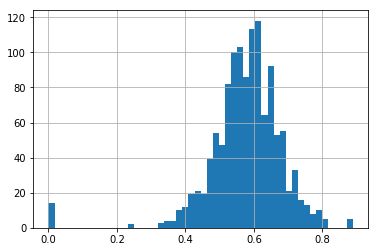

In [45]:
cos_matrix = nv.cosine_matrix()
cos_matrix = cos_matrix[np.tril_indices_from(cos_matrix, k=-1)]
pd.Series(cos_matrix).hist(bins=50)


In [86]:
agg_threshold = np.quantile(cos_matrix, 0.3)

### Classifier & Clusterizer

* Samples of interesting news from different people
* Split each sample into train and test _(if there are enough data, otherwise...?)_
* Try to find a meaningful threshold for AgglomerativeClustering AND a meaningful radius for RadiusNeighbours, that give satisfactory results for each of data samples
* Experiment, if a connectivity matrix could be useful (and select k_neighbors)

In [87]:
clust = AgglomerativeClustering(n_clusters=None, affinity='cosine', #connectivity=conn_matrix, 
                                distance_threshold=agg_threshold, linkage='complete').fit(news)

In [88]:
clust.labels_

array([ 6,  3,  1,  1,  6,  1,  0,  1,  3,  2,  6,  3, 11,  5,  6,  0,  0,
       11,  0,  4, 11, 14,  1, 10, 14,  5,  8,  3,  8,  8, 12,  2,  7,  9,
       10,  3,  2,  5,  5, 10, 13, 12,  4, 11, 13,  9,  3,  9,  6, 14],
      dtype=int64)

### Schnittstelle-Klasse zu GUI

(volle Funktionalität, erfordert alle oben definierten Klassen)

In [173]:
class Communicator:
    '''Application start -> initialize Communicator instance and call `start()`
    to start an existing system or create a new system and get DataFrames, e.g.:
    
    `CI = Communicator()
    news_in_categories, interesting_news = CI.start()
    display(news_in_categories)`
    
    Then use `handle_input()` to process user input and get system output, e.g.:
    
    `news_in_categories, interesting_news = CI.handle_input(u_input='upd')` '''   
    
    def __init__(self, feeds='default', model='default', path_dict='default', data_items_names='default', 
                 n_from_cats=10, n_interesting=20, n_similar=5, THRESHOLD=20):
        
        if feeds == 'default':
            self.feeds = ['http://feeds.bbci.co.uk/news/rss.xml', 
                          'http://feeds.bbci.co.uk/news/world/rss.xml', 
                          'http://feeds.bbci.co.uk/news/uk/rss.xml', 
                          'http://feeds.bbci.co.uk/news/business/rss.xml', 
                          'http://feeds.bbci.co.uk/news/politics/rss.xml', 
                          'http://feeds.bbci.co.uk/news/health/rss.xml', 
                          'http://feeds.bbci.co.uk/news/education/rss.xml', 
                          'http://feeds.bbci.co.uk/news/science_and_environment/rss.xml', 
                          'http://feeds.bbci.co.uk/news/technology/rss.xml', 
                          'http://feeds.bbci.co.uk/news/entertainment_and_arts/rss.xml']
        else:
            self.feeds = feeds
            
        if model == 'default':
            self.model = Embeddings().model
        else:
            self.model = model
        
        if path_dict == 'default':
            self.path_dict = {'csv':{'df_viewed':'df_viewed.csv', 
                                     'df_labeled':'df_labeled.csv', 
                                     'clust_weights':'clust_weights.csv'}, 
                              'serialized':{'classifier':'classifier', 
                                            'clusterizer':'clusterizer'}}
        else:
            self.path_dict = path_dict
            
        if data_items_names == 'default':
            self.data_items_names = ['df_viewed', 'df_labeled', 'clust_weights', 'classifier', 'clusterizer']
        else:
            self.data_items_names = data_items_names
        
        self.STATE = None
        self.n_from_cats = n_from_cats
        self.n_interesting = n_interesting
        self.n_similar = n_similar
        self.THRESHOLD = THRESHOLD
        
        self.DM = None
        self.NFind = None
        self.AGG = None
        
        self.RSS = RSS_Feeds(self.feeds)
        self.NVec = News_Vectorizer(model=self.model)
        
        # TODO: CHANGE MODELS!
        
        self.init_classification_model = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='cosine')
        self.init_clustering_model = AgglomerativeClustering(n_clusters=5, affinity='cosine', linkage='complete')

        #...
        
        
    
    def create_new_system(self):
        # create a new system without any already existing data
        self.DM = Data_Manager()
        self.AGG = Aggregator(self.init_clustering_model, self.init_classification_model)
        
        self.DM.update_data_item('df_news', self.RSS.df_news, concat=False)
        self.DM.update_data_item('df_viewed', pd.DataFrame(columns=self.RSS.df_news.columns), concat=False) # DF for viewed news
        self.DM.update_data_item('classifier', self.AGG.classifier, concat=False)
        self.DM.update_data_item('clusterizer', self.AGG.clusterizer, concat=False)
        return True
    
    def load_data_models(self):
        # try to load data and check if all data items in data_items_names in data_dict
        # set STATE ('ALL' - already fitted model, all data; 'NOT FITTED' - not fitted yet, some data; 'NEW' - no data)

        self.DM = Data_Manager(path_dict=self.path_dict)
        if len([i for i in self.data_items_names if i not in self.DM.data_dict.keys()]) == 0:
            return ('ALL')
        elif ('df_viewed' in self.DM.data_dict.keys()) and ('clust_weights' not in self.DM.data_dict.keys()):
            return 'NOT FITTED'
        else:
            return 'NEW'
        
    def select_news(self):
        categories = self.NFind.get_from_categories(n=self.n_from_cats)
        if self.STATE == 'ALL':
            interesting = self.NFind.get_interesting(self.AGG, n=self.n_interesting)
        else:
            interesting = self.NFind.df_unique_news.sample(self.n_interesting)
        return categories, interesting
    
    def check_viewed(self):
        # check and remove already viewed news from news DataFrame
        if self.STATE == 'ALL':
            viewed_id = np.hstack([self.DM.get_data_item('df_labeled').ID.values, self.DM.get_data_item('df_viewed').ID.values])
        elif self.STATE == 'NOT FITTED':
            viewed_id = self.DM.get_data_item('df_viewed').ID.values
        self.DM.update_data_item('df_news', self.RSS.df_news.query('ID not in @viewed_id'), concat=False)
        return True
    
    def start(self):
        #try to load data
        #if 'ALL' -> start existing
        #if 'NEW' -> call `create_new_system` and change STATE
        #if 'NOT FITTED' -> init aggregator with existing models
        # return DataFrames
        
        self.STATE = self.load_data_models()
        
        if self.STATE == 'NOT FITTED':
            self.AGG = Aggregator(clusterizer=self.DM.get_data_item('clusterizer'), 
                                  classifier=self.DM.get_data_item('classifier'))
            # filter already viewed news
            self.check_viewed()          
            
        elif self.STATE == 'ALL':
            self.DM.delete_old('df_labeled')    
            self.AGG = Aggregator(clusterizer=self.DM.get_data_item('clusterizer'), 
                                  classifier=self.DM.get_data_item('classifier'), 
                                  labeled_data=self.NVec.news2vec(self.DM.get_data_item('df_labeled').news.values), 
                                  labels=self.DM.get_data_item('df_labeled').label.values, 
                                  clust_weights=self.DM.get_data_item('clust_weights'))
            # filter already viewed news
            self.check_viewed()
        
        elif self.STATE == 'NEW':
            self.create_new_system()
            self.STATE = 'NOT FITTED'
        
        #initialize News_Finder
        self.NFind = News_Finder(self.DM.get_data_item('df_news'), News_Vectorizer(model=self.model))
        
        # get news DataFrames to show
        news_from_categories, news_interesting = self.select_news()
            
        return news_from_categories, news_interesting
    

    def handle_input(self, u_input): # the main method that GUI has to call
        ''' Call this method with `u_input` argument to communicate with the system.
            It takes a string `u_input` and returns appropriate output.
            
            Interactions as `u_input` -> `method output`:
            
            * 'upd' -> two pandas DataFrame objects (news in categories, interesting news)
            * 'exit' -> boolean: True, if data and models have been successfully saved, False otherwise
            * 'viewed' + ' ' + ID (e.g. 'viewed 005503512f38f130303cb133d656203b') -> two pandas DataFrame objects (news in categories, interesting news)
            * 'similar' + ' ' + ID (e.g. 'similar dc313bbf1bfca18d28e95862e972822f') -> pandas DataFrame with nearest news            
        '''
        # parse GUI input
        # call appropriate methods
        # return system output to GUI
        instruction = u_input.split()[0]
        if instruction == 'upd':
            #update news
            categories, interesting = self.update_news()
            return categories, interesting
        
        elif instruction == 'exit':
            is_saved = self.save()
            return is_saved
        
        elif instruction == 'viewed':
            #get news id and process viewed...
            n_id = u_input.split()[1:] # list, even if it consists of only one ID (generally)
            categories, interesting = self.handle_viewed(n_id)
            return categories, interesting

        elif instruction == 'similar':
            #get id and return similar
            n_id = u_input.split()[1] # string
            similar_news = self.find_similar(n_id)
            return similar_news

        else:
            return('unknown input')
        
    
    def update_news(self):
        # download news from rss feeds
        self.RSS = RSS_Feeds(self.feeds)
        
        # filter already viewed news
        self.check_viewed()
        
        # update news in News_Finder
        self.NFind.update_news(self.DM.get_data_item('df_news'))
        # return DataFrames
        news_from_categories, news_interesting = self.select_news()
            
        return news_from_categories, news_interesting
    
    def save(self):
        try:
            self.DM.save_model()
            return True
        except:
            return False
    
    def handle_viewed(self, n_id): #n_id : list
        # get news ID, check if already in viewed, remove from all news,.....
        viewed = self.NFind.df_unique_news.query('ID in @n_id')
        self.NFind.update_news(self.NFind.df_news.query('ID not in @n_id')) #filter already viewed and update data
        self.DM.update_data_item('df_viewed', viewed, concat=True)
        self.DM.update_data_item('df_news', self.NFind.df_news, concat=False)

        # if n(viewed) >= THRESHOLD -> update model -> save model
        if self.DM.get_data_item('df_viewed').shape[0] >= self.THRESHOLD:
            #update aggregator
            data = self.DM.get_data_item('df_viewed')
            colnames = data.columns
            self.AGG.update_aggregator(self.NVec.news2vec(data.news))
            
            #update df_labeled
            if self.STATE == 'ALL':
                data = pd.concat([self.DM.get_data_item('df_labeled').drop('label', axis=1), data])
            data['label'] = self.AGG.labels
            self.DM.update_data_item('df_labeled', data, concat=False)
            
            #update df_viewed (empty)
            self.DM.update_data_item('df_viewed', pd.DataFrame(columns=colnames), concat=False)
            
            #update data_items: classifier, clusterizer etc
            self.DM.update_data_item('classifier', self.AGG.classifier, concat=False)
            self.DM.update_data_item('clusterizer', self.AGG.clusterizer, concat=False)
            self.DM.update_data_item('clust_weights', self.AGG.clust_weights, concat=False)
            
            # update STATE
            self.STATE = 'ALL'
            
            #save model
            self.save()
            
        # return DataFrames
        news_from_categories, news_interesting = self.select_news()
        return news_from_categories, news_interesting
    
    
    def find_similar(self, n_id): #n_id : str
        # return the n nearest news to the given news item
        return self.NFind.get_similar(news_item_ID=n_id, n=self.n_similar)

In [174]:
CI = Communicator()

In [175]:
c, i = CI.start()

In [177]:
CI.handle_input('similar 27264bb9d3de2a141edef97719325ec6')

,ID,news,category,title,summary,link,date,time,datetime,dist
9,0d4672e62df468fd908b194960a9ddc3,Susan Warby death: Whistleblower letter to hus...,[BBC News - Health],Susan Warby death: Whistleblower letter to hus...,The hospital reportedly demanded fingerprints ...,https://www.bbc.co.uk/news/uk-england-suffolk-...,"(2020, 1, 17)","(15, 45, 13)","Fri, 17 Jan 2020 15:45:13 GMT",0.434158
223,e4566e9bef272bd0dab80bd03304a549,Spotify's personalised playlist for pets and o...,[BBC News - Technology],Spotify's personalised playlist for pets and o...,BBC Click's Paul Carter looks at some of the b...,https://www.bbc.co.uk/news/technology-51148061,"(2020, 1, 17)","(11, 25, 38)","Fri, 17 Jan 2020 11:25:38 GMT",0.450537
46,33c983b14bd79e113680dbdda08e0512,Mistaken identity: 'You called the wrong Rober...,"[BBC News - UK Politics, BBC News - Entertainm...",Mistaken identity: 'You called the wrong Rober...,Presenter Evan Davis said it was the worst mis...,https://www.bbc.co.uk/news/uk-51142491,"(2020, 1, 16)","(21, 25, 52)","Thu, 16 Jan 2020 21:25:52 GMT",0.461227
10,0d7b310d3afcf4fdcc224fb0a3486727,Putin's plans: What Russian president's surpri...,[BBC News - World],Putin's plans: What Russian president's surpri...,"New PM, new government and plans to change the...",https://www.bbc.co.uk/news/world-europe-51142210,"(2020, 1, 16)","(20, 43, 35)","Thu, 16 Jan 2020 20:43:35 GMT",0.470574
222,e3ffc59c2fd7baf99c94edf626c572e2,Manchester mayor criticises Eminem for rap abo...,[BBC News - Entertainment & Arts],Manchester mayor criticises Eminem for rap abo...,Andy Burnham calls the rap about the 2017 atta...,https://www.bbc.co.uk/news/entertainment-arts-...,"(2020, 1, 17)","(17, 49, 50)","Fri, 17 Jan 2020 17:49:50 GMT",0.475139


In [168]:
nc, ni = CI.handle_input('upd')

In [178]:
CI.handle_input('exit')

True

### "Dummy" Communicator für die GUI Entwicklung


class Communicator:
    '''Application start -> initialize Communicator instance and call `start()`
    to start an existing system or create a new system and get DataFrames, e.g.:
    
    `CI = Communicator()
    news_in_categories, interesting_news = CI.start()
    display(news_in_categories)`
    
    Then use `handle_input()` to process user input and get system output, e.g.:
    
    `news_in_categories, interesting_news = CI.handle_input(u_input='upd')`
    
    '''
    
    def __init__(self): # Application start -> initialize Communicator instance 
        # call `start` to start an existing system or create a new system
        self.RSS = RSS_Feeds(bbc_rss)
        #self.start()
    
    def create_new_system(self):
        # create a new system without any already existing data
        pass
    
    def load_data_models(self):
        pass
        
    def select_news(self):
        categories = self.RSS.df_news.groupby('category').head(10)
        interesting = self.RSS.df_unique_news.sample(n=np.random.randint(15, 25), random_state=42)
        return categories, interesting
    
    def start(self):
        #try to load data
        #if ok -> start existing
        #if smth is not ok -> call `create_new_system`
        # return DataFrames
        c, i = self.select_news()
        return c, i


    def handle_input(self, u_input): # the main method that GUI has to call
        ''' Call this method with `u_input` argument to communicate with the system.
            It takes a string `u_input` and returns you appropriate method output.
            
            Interactions as `u_input` -> `method output`:
            
            * 'upd' -> two pandas DataFrame objects (news in categories, interesting news)
            * 'exit' -> boolean: True, if data and models have been successfully saved, False otherwise
            * 'viewed' + ' ' + ID (e.g. 'viewed 005503512f38f130303cb133d656203b') -> two pandas DataFrame objects (news in categories, interesting news)
            * 'similar' + ' ' + ID (e.g. 'similar dc313bbf1bfca18d28e95862e972822f') -> pandas DataFrame with nearest news            
        '''
        # parse GUI input
        # call appropriate methods
        # return system output to GUI
        instruction = u_input.split()[0]
        if instruction == 'upd':
            #update news
            self.RSS = RSS_Feeds(bbc_rss)
            c, i = self.select_news()
            return c, i
        elif instruction == 'exit':
            #save
            return True
        elif instruction == 'viewed':
            #get news id and process viewed...
            n_id = u_input.split()[1:] # list, even if it consists of only one ID (generally)
            c, i = self.select_news()
            return c, i
        elif instruction == 'similar':
            #get id and return similar
            n_id = u_input.split()[1] # string
            return self.RSS.df_unique_news.sample(n=5, random_state=111)
        else:
            return('unknown input')
        
    
    def update_news(self):
        # download news from rss feeds
        # return DataFrames
        pass
    
    def save(self):
        # save data and models
        # return ok or error
        pass
    
    def handle_viewed(self):
        # get news ID, check if already in viewed, remove from all news,.....
        # if n(viewed) >= THRESHOLD -> update model -> save mpdel
        # return DataFrames
        pass
    
    def find_similar(self, n):
        # get and return the n nearest news to the given news item
        pass